<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras

content_img_path = keras.utils.get_file('korea_univ.jpg', origin='https://www.dailysmart.co.kr/news/photo/202209/64583_66813_136.jpg')
style_img_path = keras.utils.get_file('gogang.jpg', origin='https://res.heraldm.com/content/image/2022/12/02/20221202000591_0.jpg')
original_width, original_height = keras.utils.load_img(content_img_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

1299557/1299557 [==============================] - 1s 1us/step


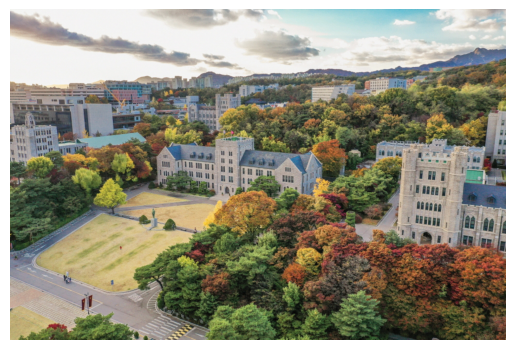

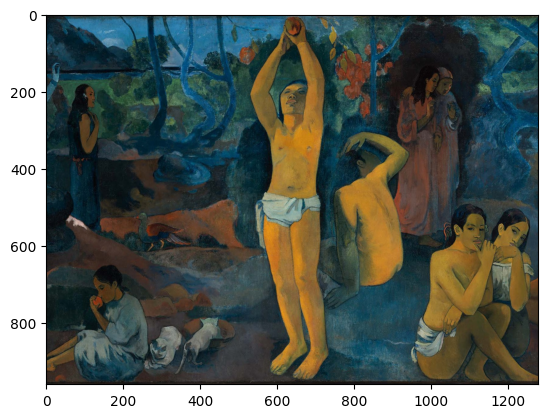

In [ ]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(keras.utils.load_img(content_img_path))
plt.show()
plt.imshow(keras.utils.load_img(style_img_path))
plt.show()


In [ ]:
import numpy as np

def preprocess_image(img_path):
    img = keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)

    return img


def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')

    return img

In [ ]:
model = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)

output_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(model.inputs, output_dict)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf

def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

def total_variation_loss(x):
    a = tf.square(x[:, :img_height-1, :img_width-1, :] - x[:, 1:, :img_width-1, :])
    b = tf.square(x[:, :img_height-1, :img_width-1, :] - x[:, :img_height-1, 1:, :])
    return tf.reduce_sum(tf.pow(a+b, 1.25))

In [ ]:
style_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_layer_name= 'block5_conv2'
total_variation_weight = 1e-6
style_weigt = 1e-6
content_weight = 2.5e-6

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, : ,: ,:]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_reference_features, combination_features)
        loss += (style_weigt / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100., decay_steps=100, decay_rate=0.96))
optimizer = keras.optimizers.Adam(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5., decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(content_img_path)
style_reference_image = preprocess_image(style_img_path)
combination_image = tf.Variable(preprocess_image(content_img_path))

iterations = 4000
for i in range(1, iterations+1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f'{i}th iter: loss={loss:.2f}')

        img = deprocess_image(combination_image.numpy())
        fname = f"kroea_gogang_{i}.png"
        keras.utils.save_img(fname, img)

100th iter: loss=1242.36
200th iter: loss=1003.54
300th iter: loss=879.52
400th iter: loss=917.15
500th iter: loss=1013.46
600th iter: loss=723.16
700th iter: loss=719.13
800th iter: loss=686.89
900th iter: loss=673.09
1000th iter: loss=656.59
1100th iter: loss=650.78
1200th iter: loss=690.66
1300th iter: loss=622.00
1400th iter: loss=617.24
1500th iter: loss=638.93
1600th iter: loss=601.38
1700th iter: loss=600.16
1800th iter: loss=607.17
1900th iter: loss=603.17
2000th iter: loss=582.09
2100th iter: loss=582.65
2200th iter: loss=581.17
2300th iter: loss=573.82
2400th iter: loss=571.01
2500th iter: loss=566.65
2600th iter: loss=567.97
2700th iter: loss=565.37
2800th iter: loss=560.27
2900th iter: loss=560.87
3000th iter: loss=557.43
3100th iter: loss=558.44
3200th iter: loss=555.25
3300th iter: loss=553.59
3400th iter: loss=552.04
3500th iter: loss=552.24
3600th iter: loss=550.09
3700th iter: loss=549.25
3800th iter: loss=553.22
3900th iter: loss=547.48
4000th iter: loss=546.23


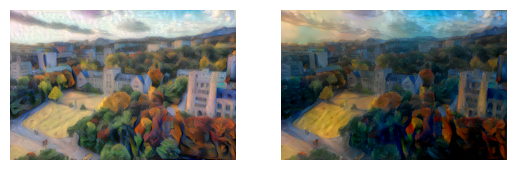

In [ ]:
from tensorflow.python import platform
import matplotlib.pyplot as plt


plt.subplot(1, 2, 1)
plt.imshow(keras.utils.load_img(f"kroea_gogang_{100}.png"))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(keras.utils.load_img(f"kroea_gogang_{4000}.png"))
plt.axis("off")
plt.show()

In [ ]:
|from tensorflow.python import platform
import matplotlib.pyplot as plt

cols = 4
rows = iterations // 100 // cols

for i in range(1, iterations // 100 + 1):
    plt.subplot(1, cols, i%4)
    plt.imshow(keras.utils.load_img(f"kroea_gogang_
    {i*100}.png"))#.numpy().astype('int8'))
    plt.axis("off")
    if i % cols == 0:
        plt.show()